# **Blood Cell Cancer Classification Using MedNet and Advanced Segmentation**

## Project Overview
### Objective
Develop an automated system for classifying blood cell images to detect cancer using deep learning and advanced image processing techniques.

### Dataset

- **Source**: Blood Cell Cancer [ALL] dataset
- **Classes**: 4 categories
  - Benign (Normal cells)
  - [Malignant] Early Pre-B
  - [Malignant] Pre-B
  - [Malignant] Pro-B


- **Total Images**: ~3000+ samples
- **Split**: 90% training, 10% testing

#### Methodology
Combines traditional computer vision (segmentation) with modern deep learning (MobileNetV2) for enhanced classification accuracy.


## Environment Setup

#### Step 1: Install Required Libraries


In [1]:
# !pip install imutils : is used to install the imutils package, which simplifies common image processing tasks with OpenCV.
# such as resizing, rotating, and displaying images.


!pip install imutils

#### Step 2: Import Essential Libraries

In [2]:
# This code block imports all the essential libraries for deep learning, image preprocessing, clustering, and model evaluation.
# It prepares the environment for training transfer learning models such as InceptionV3 and DenseNet201 on image data.

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
import itertools

from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics


from tensorflow.keras.applications import InceptionV3, MobileNetV2



#### Step 3: Configuration Settings

**Why these settings?**

- Mixed precision reduces training time while maintaining accuracy
- Random seeds ensure reproducible results
- 224x224 is optimal for MobileNetV2 input
- Batch size of 64 balances memory usage and training speed

In [ ]:
# Enable mixed precision for faster training
set_global_policy('mixed_float16')

# Set random seeds for reproducibility
np.random.seed(88)
tf.random.set_seed(88)
random.seed(88)

# Configuration
BATCH_SIZE = 64  # Increased batch size for faster training
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)
SPLIT = 0.90
PREFETCH_BUFFER = tf.data.AUTOTUNE

## Data Loading and Preparation

#### Step 1: Mount Google Drive and Set Paths & Load and Shuffle Data

In [3]:
'''
This code
1.mounts Google Drive,
2. loads all image paths from a dataset folder,
3. shuffles them for randomness,
4. then splits them into training and testing sets using a 90/10 ratio.
It's a standard data preparation step for building a deep learning model using medical image data.

'''

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset directory in Google Drive
data_dir = '/content/drive/MyDrive/Blood cell Cancer [ALL]'

from imutils import paths
import random
from sklearn.model_selection import train_test_split

# List all image file paths in the dataset directory and sort them
data_list = sorted(list(paths.list_images(data_dir)))


random.seed(88)            # Set a seed to ensure reproducibility of the shuffl
random.shuffle(data_list)  # Shuffle the list of image paths randomly

# Split the dataset into training and testing sets
train_list, test_list = train_test_split(
    data_list,            # Use the shuffled image paths
    train_size=0.90,      # 90% for training
    shuffle=True,         # Shuffle before splitting
    random_state=88       # Set random seed for reproducibility
    )

print('Number of training images:', len(train_list))
print('Number of testing images:', len(test_list))



Mounted at /content/drive
Number of training images: 2917
Number of testing images: 325


In [4]:
# Show the full file paths of the testing images.

test_list

['/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_819.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_136 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_233 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_146.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_259.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_235 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pro-B/Snap_161.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_289.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/Benign/Snap_072 (3).jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_300.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snp_147 (145).jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malig

#### Step 2: Analyze Dataset Distribution


In [5]:
'''
Prints the total number of images in the dataset.
Then displays the number of images in each class (Benign, and three Malignant subtypes).
It's useful for checking class balance before training a model.

'''

print('Number of samples in dataset:',len(list(paths.list_images(data_dir))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images(f"{data_dir}/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images(f"{data_dir}/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images(f"{data_dir}/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images(f"{data_dir}/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


#### Dataset Statistics
The dataset contains blood cell images across four categories:

- **Benign**: Normal blood cells:
- **Malignant [Early Pre-B]**: Early stage malignant cells
- **Malignant [Pre-B]**: Pre-B malignant cells
- **Malignant [Pro-B]**: Pro-B malignant cells

#### Key Metrics:
- Total training images: ~2,600+ samples
- Total testing images: ~290+ samples
- Image format: Various (JPEG, PNG)
- Target size: 224×224 pixels

#### Key Insights:
- Understand class imbalance
- Plan stratified sampling
- Determine augmentation needs

## Advanced Image Segmentation

#### Step 1: Create Output Directories

In [6]:
import os

# Define the root directory inside Google Drive where all folders will be created
base_dir = '/content/drive/MyDrive/prepared_dataset'

# List of relative subfolder paths for training and testing data, organized by class
train_dirs = [
    'prepared_data/benign',
    'prepared_data/PreB',
    'prepared_data/ProB',
    'prepared_data/EarlyPreB',
    'prepared_test/benign',
    'prepared_test/PreB',
    'prepared_test/ProB',
    'prepared_test/EarlyPreB'
]

# إنشاء المجلدات
for d in train_dirs:
    dir_path = os.path.join(base_dir, d)   # Combine base path with the subfolder path
    os.makedirs(dir_path, exist_ok=True)   # Create the directory if it doesn't already exist

print("✅ All folders created successfully inside Google Drive.")

✅ All folders created successfully inside Google Drive.


#### Step 2: Process Test Data

In [ ]:
# import cv2
# import os

# p = 0                                     # Initialize counter for naming saved images

# for img in test_list:                     # Loop through each image path in the test dataset
#     i = cv2.imread(img)                   # Read the image using OpenCV
#     i = cv2.resize(i, (224, 224))         # Resize image to 224x224 (standard size for CNN models)

#     # Extract the class label from the parent folder name
#     lable = os.path.basename(os.path.dirname(img))

#     # Choose the destination path based on the label
#     if lable == "Benign":
#         b = f'{base_dir}/prepared_test/benign/{lable}_{p}.png'
#     elif lable == "[Malignant] Pre-B":
#         b = f'{base_dir}/prepared_test/PreB/{lable}_{p}.png'
#     elif lable == "[Malignant] Pro-B":
#         b = f'{base_dir}/prepared_test/ProB/{lable}_{p}.png'
#     elif lable == "[Malignant] early Pre-B":
#         b = f'{base_dir}/prepared_test/EarlyPreB/{lable}_{p}.png'
#     else:
#         # If label doesn't match expected values
#         print(f"❗ Unknown label found: {lable}")
#         continue        # Skip the image

#     cv2.imwrite(b, i)   # Save the resized image to the target folder
#     p += 1              # Increment the counter for the next image


#### Step 3: Process Training Data with Segmentation and apply Segmentation Algorithm Implementation
The segmentation process follows these key steps:
-  Color Space Conversion
-  K-Means Clustering
-  Binary Thresholding
-  Morphological Operations
-  Complete Segmentation Pipeline


In [ ]:
# p=0                                                     # Initialize a counter for image naming
# tic = time.perf_counter()

# for img in train_list:                                  # Loop through each image path in the training dataset

#     i= cv2.imread(img)                                  # Read the image using OpenCV
#     i= cv2.resize(i,(224,224))                          # Resize image to 224x224 pixels
#     lable = os.path.basename(os.path.dirname(img))      # Extract class label from parent folder name

#     if (lable=="Benign"):
#         b= (f'{base_dir}/prepared_data/benign/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pre-B"):
#         b= (f'{base_dir}/prepared_data/PreB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pro-B"):
#         b= (f'{base_dir}/prepared_data/ProB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] early Pre-B"):
#         b= (f'{base_dir}/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
#     p+=1                # Increment counter
#     cv2.imwrite(b,i)    # Save the resized image

#     #-------- Segmentation ---------
#     i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)             # Convert BGR to RGB
#     i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        # Convert RGB to LAB color space
#     l,a,b = cv2.split(i_lab)                          # Split LAB channels
#     i2 = a.reshape(a.shape[0]*a.shape[1],1)           # Flatten the 'a' channel for clustering
#     km= KMeans(n_clusters=7, random_state=0).fit(i2)  # Apply KMeans clustering on 'a' channel
#     p2s= km.cluster_centers_[km.labels_]              # Get clustered pixel values
#     ic= p2s.reshape(a.shape[0],a.shape[1])            # Reshape back to image shape
#     ic = ic.astype(np.uint8)
#     r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)# Apply binary threshold
#     fh = ndi.binary_fill_holes(t)                     # Fill holes inside the segmented region
#     m1 = morphology.remove_small_objects(fh, 200)     # Remove small noise
#     m2 = morphology.remove_small_holes(m1,250)        # Remove small holes
#     m2 = m2.astype(np.uint8)
#     out = cv2.bitwise_and(i, i, mask=m2)              # Apply segmentation mask to original image

#     if (lable=="Benign"):
#         b= (f'{base_dir}/prepared_data/benign/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pre-B"):
#         b= (f'{base_dir}/prepared_data/PreB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pro-B"):
#         b= (f'{base_dir}/prepared_data/ProB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] early Pre-B"):
#         b= (f'{base_dir}/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
#     p+=1                                             # Increment counter
#     out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)        # Convert back to BGR for saving
#     cv2.imwrite(b,out)                               # Save segmented image

# toc2 = time.perf_counter()                           # End the timer
# print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

#### Step 4: Visualization of Segmentation Steps

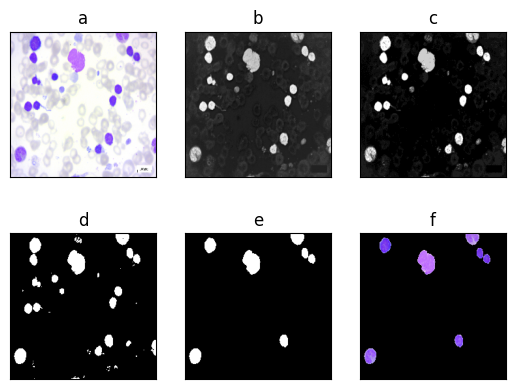

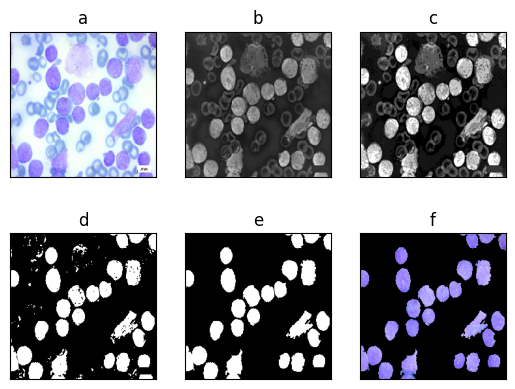

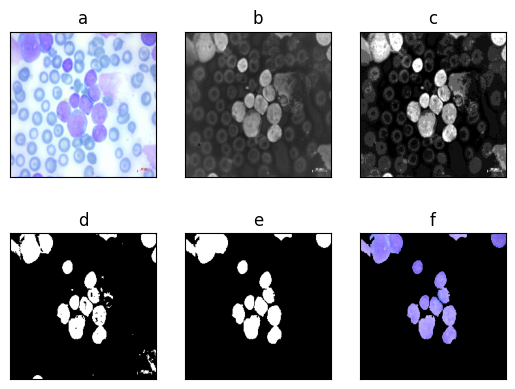

In [8]:
#----- print some samples of training dataset -------

# Set how many sample images to visualize
n = 3

# Lists to store intermediate image processing steps
o_img = []                        # Original RGB images
a_img = []                        # 'a' channel from LAB color space
c_img = []                        # Clustered version of 'a' channel
b_img = []                        # Binary thresholded image
m_img = []                        # Morphological mask after removing small objects/holes
out_img = []                      # Final segmented output image

random.seed(865)                  # For reproducibility
random.shuffle(data_list)         # Shuffle the image list

# Loop through first `n` images for visualization
for img in data_list[:n]:
    i = cv2.imread(img)                             # Read image
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)          # Convert to RGB
    i = cv2.resize(i, (224, 224))                   # Resize image
    o_img.append(i)                                 # Save original image

    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)      # Convert to LAB color space
    l, a, b = cv2.split(i_lab)                      # Split channels
    a_img.append(a)                                 # Save 'a' channel

    # Flatten the 'a' channel for clustering
    i2 = a.reshape(a.shape[0]*a.shape[1], 1)

    # Apply KMeans
    km = KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s = km.cluster_centers_[km.labels_]           # Get pixel values from cluster centers
    ic = p2s.reshape(a.shape[0], a.shape[1])        # Reshape to image size
    ic = ic.astype(np.uint8)
    c_img.append(ic)                                # Save clustered image

    # Apply binary threshold
    r, t = cv2.threshold(ic, 141, 255, cv2.THRESH_BINARY)
    b_img.append(t)                                 # Save thresholded image

    fh = ndi.binary_fill_holes(t)                   # Fill internal holes
    m1 = morphology.remove_small_objects(fh, 200)   # Remove small noise
    m2 = morphology.remove_small_holes(m1, 250)     # Remove small holes
    m2 = m2.astype(np.uint8)
    m_img.append(m2)                                # Save final segmentation mask

    out = cv2.bitwise_and(i, i, mask=m2)            # Apply the mask to original image
    out_img.append(out)                             # Save final segmented image

# Loop through all visualized images
for j in range(n):
    for t in range(1):

        # Original
        plt.subplot(2, 3, 1 + t), plt.imshow(o_img[j])
        plt.title('a'), plt.xticks([]), plt.yticks([])

        # 'a' channel
        plt.subplot(2, 3, 2 + t), plt.imshow(a_img[j], 'gray')
        plt.title('b'), plt.xticks([]), plt.yticks([])

        # Clustered
        plt.subplot(2, 3, 3 + t), plt.imshow(c_img[j], 'gray')
        plt.title('c'), plt.xticks([]), plt.yticks([])

        # Thresholded
        plt.subplot(2, 3, 4 + t), plt.imshow(b_img[j], 'gray')
        plt.title('d'), plt.xticks([]), plt.yticks([])

        # Final mask
        plt.subplot(2, 3, 5 + t), plt.imshow(m_img[j], 'gray')
        plt.title('e'), plt.xticks([]), plt.yticks([])

        # Segmented output
        plt.subplot(2, 3, 6 + t), plt.imshow(out_img[j])
        plt.title('f'), plt.xticks([]), plt.yticks([])

    # Display all 6 steps for one image
    plt.show()


## Dataset Processing

#### Step 1: Optimized Image Preprocessing


In [11]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess single image with optimizations
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # Normalize to [0,1]
    image = image.astype(np.float32) / 255.0

    return image

In [12]:
def load_and_preprocess_image(image_path):
    """
    Fast image loading and preprocessing using TensorFlow ops
    """
    # Read image file
    image = tf.io.read_file(image_path)

    # Decode image (supports JPEG, PNG, GIF, BMP)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)

    # Convert to float32 and normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Resize image
    image = tf.image.resize(image, [224, 224])

    # Ensure shape is set
    image.set_shape([224, 224, 3])

    return image

#### Step 2: Optimized Dataset Creation

In [13]:
def create_dataset_from_dataframe(df, batch_size, shuffle=True, augment=False):
    """
    Create optimized tf.data.Dataset from DataFrame using native TF operations
    """
    # Create label encoder using actual labels from data
    unique_labels = sorted(df['labels'].unique())
    print(f"Creating dataset with labels: {unique_labels}")
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to indices
    df_indexed = df.copy()
    df_indexed['label_idx'] = df_indexed['labels'].map(label_to_index)

    # Check for any unmapped labels
    if df_indexed['label_idx'].isna().any():
        unmapped_labels = df_indexed[df_indexed['label_idx'].isna()]['labels'].unique()
        print(f"Warning: Found unmapped labels: {unmapped_labels}")
        # Remove rows with unmapped labels
        df_indexed = df_indexed.dropna(subset=['label_idx'])

    # Create dataset from file paths
    file_paths = tf.constant(df_indexed['filenames'].values)
    labels = tf.constant(df_indexed['label_idx'].values, dtype=tf.int32)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Map loading function
    dataset = dataset.map(
        lambda path, label: (load_and_preprocess_image(path), tf.one_hot(label, len(unique_labels))),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentation if needed
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle if needed
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(1000, len(df_indexed)))

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, unique_labels

#### Step 3: Data Augmentation
**Augmentation benefits:**

- Increases effective dataset size
- Improves model generalization
- Reduces overfitting
- Simulates real-world variations

In [14]:
def augment_image(image, label):
    """
    Apply data augmentation
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Ensure values stay in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

#### 🏥 MedNet Model and Fine-Tuning Strategies

In [15]:
def create_mednet_model(num_classes):
    """
    Create MedNet model architecture
    """
    # Input
    input_layer = Input(shape=(224, 224, 3))

    # MedNet Base Model
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Pooling
    x = GlobalAveragePooling2D()(x)

    # Classification Head
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

    # Full MedNet Model
    model = Model(inputs=input_layer, outputs=predictions)

    return model

#### fine_tune_model_strategy_A

In [16]:
def fine_tune_model_strategy_A(model, train_dataset, valid_dataset, unfreeze_layers_list=[10],
                               lr=0.00001, epochs=10):
    """
    Strategy A: Experiment with multiple unfreeze layer settings for fine-tuning.
    """
    histories = {}

    for unfreeze_layers in unfreeze_layers_list:
        print(f"\n--- Fine-tuning with last {unfreeze_layers} layers unfrozen ---")

        # Clone the model to avoid cumulative fine-tuning
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())

        # Freeze all layers initially
        for layer in model_copy.layers:
            layer.trainable = False

        # Count total layers
        total_layers = len(model_copy.layers)
        print(f"Total layers in model: {total_layers}")

        # Unfreeze the specified number of layers from the end
        for i in range(total_layers - unfreeze_layers, total_layers):
            if i >= 0:
                model_copy.layers[i].trainable = True
                print(f"Unfreezing layer {i}: {model_copy.layers[i].name}")

        # Recompile the model
        model_copy.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=lr),
            metrics=['accuracy']
        )

        # Count trainable parameters
        trainable_params = np.sum([np.prod(w.shape) for w in model_copy.trainable_weights])
        non_trainable_params = np.sum([np.prod(w.shape) for w in model_copy.non_trainable_weights])
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Non-trainable parameters: {non_trainable_params:,}")

        # Train the model
        history = model_copy.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            callbacks=[
                EarlyStopping(patience=3, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
            ],
            verbose=1
        )

        histories[unfreeze_layers] = history

    return histories

#### fine_tune_model_strategy_B

In [17]:
def fine_tune_model_strategy_B(model, train_dataset, valid_dataset, unfreeze_from_index=9,
                               lr=0.00001, epochs=10):
    """
    Strategy B: Unfreeze from specific block onward
    """
    print(f"\n--- Fine-tuning from layer index {unfreeze_from_index} onward ---")

    # Clone the model
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    # Freeze/unfreeze layers based on index
    for i, layer in enumerate(model_copy.layers):
        layer.trainable = i >= unfreeze_from_index
        if layer.trainable:
            print(f"Unfreezing layer {i}: {layer.name}")

    # Recompile model
    model_copy.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # Count trainable parameters
    trainable_params = np.sum([np.prod(w.shape) for w in model_copy.trainable_weights])
    non_trainable_params = np.sum([np.prod(w.shape) for w in model_copy.non_trainable_weights])
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    # Fine-tune the model
    history = model_copy.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
        ],
        verbose=1
    )

    return history, model_copy

#### Training and Validation Curves



In [18]:
def tr_plot(tr_data, start_epoch):
    """Plot the training and validation data with enhanced styling"""
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

#### Confusion Matrix Plotting


In [19]:
def plot_confusion_matrix(cm, target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """Plot confusion matrix with accuracy information"""
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Step 4: Create DataFrames and Datasets

In [20]:
#------- Test DataFrame ---------
print("📋 Creating Test DataFrame...")

# Directory containing the prepared test images
prepared_test_path = f'{base_dir}/prepared_test/'

# Check if test directory exists
if not os.path.exists(prepared_test_path):
    print(f"❌ Error: Test directory does not exist: {prepared_test_path}")
    print("Please check the base_dir path and folder structure.")
else:
    print(f"✅ Test directory found: {prepared_test_path}")

# Get all image file paths in the test directory
test_filenames = sorted(list(paths.list_images(prepared_test_path)))
if not test_filenames:
    print("❌ No test images found!")
else:
    print(f"✅ Found {len(test_filenames)} test images")

random.shuffle(test_filenames)

# Extract labels by getting the parent folder name of each image
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_filenames]

# Create test DataFrame
test_df = pd.DataFrame({
    'filenames': test_filenames,
    'labels': test_labels
})

print('-- Test DataFrame --')
print(test_df.head())
print('-- Number of samples in each label --')
print(test_df['labels'].value_counts())

📋 Creating Test DataFrame...
✅ Test directory found: /content/drive/MyDrive/prepared_dataset/prepared_test/
✅ Found 325 test images
-- Test DataFrame --
                                           filenames     labels
0  /content/drive/MyDrive/prepared_dataset/prepar...       PreB
1  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
2  /content/drive/MyDrive/prepared_dataset/prepar...       ProB
3  /content/drive/MyDrive/prepared_dataset/prepar...       ProB
4  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
-- Number of samples in each label --
labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64


In [21]:
#------- Train/Valid DataFrame -------
print("\n📋 Creating Train/Valid DataFrame...")

# Directory containing the prepared training/validation images
prepared_data_path = f'{base_dir}/prepared_data/'

# Check if training directory exists
if not os.path.exists(prepared_data_path):
    print(f"❌ Error: Training directory does not exist: {prepared_data_path}")
    print("Please check the base_dir path and folder structure.")
else:
    print(f"✅ Training directory found: {prepared_data_path}")

# Get all image file paths
train_valid_filenames = sorted(list(paths.list_images(prepared_data_path)))
if not train_valid_filenames:
    print("❌ No training images found!")
else:
    print(f"✅ Found {len(train_valid_filenames)} training images")

random.shuffle(train_valid_filenames)

# Extract class labels
train_valid_labels = [os.path.basename(os.path.dirname(path)) for path in train_valid_filenames]

# Create train/valid DataFrame
df = pd.DataFrame({
    'filenames': train_valid_filenames,
    'labels': train_valid_labels
})

print('-- Train/Valid DataFrame --')
print(df.head())
print('-- Number of samples in each label --')
label_counts = df['labels'].value_counts()
print(label_counts)


📋 Creating Train/Valid DataFrame...
✅ Training directory found: /content/drive/MyDrive/prepared_dataset/prepared_data/
✅ Found 5834 training images
-- Train/Valid DataFrame --
                                           filenames     labels
0  /content/drive/MyDrive/prepared_dataset/prepar...     benign
1  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
2  /content/drive/MyDrive/prepared_dataset/prepar...       ProB
3  /content/drive/MyDrive/prepared_dataset/prepar...     benign
4  /content/drive/MyDrive/prepared_dataset/prepar...     benign
-- Number of samples in each label --
labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64


In [22]:
# Display all unique labels
print(f"All unique labels in training data: {sorted(df['labels'].unique())}")
print(f"All unique labels in test data: {sorted(test_df['labels'].unique())}")

All unique labels in training data: ['EarlyPreB', 'PreB', 'ProB', 'benign']
All unique labels in test data: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [23]:
# Get actual labels from the data
actual_labels = list(label_counts.index)
print(f"Actual labels found in data: {actual_labels}")


Actual labels found in data: ['EarlyPreB', 'PreB', 'ProB', 'benign']


<ipython-input-24-3f83350129c9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)


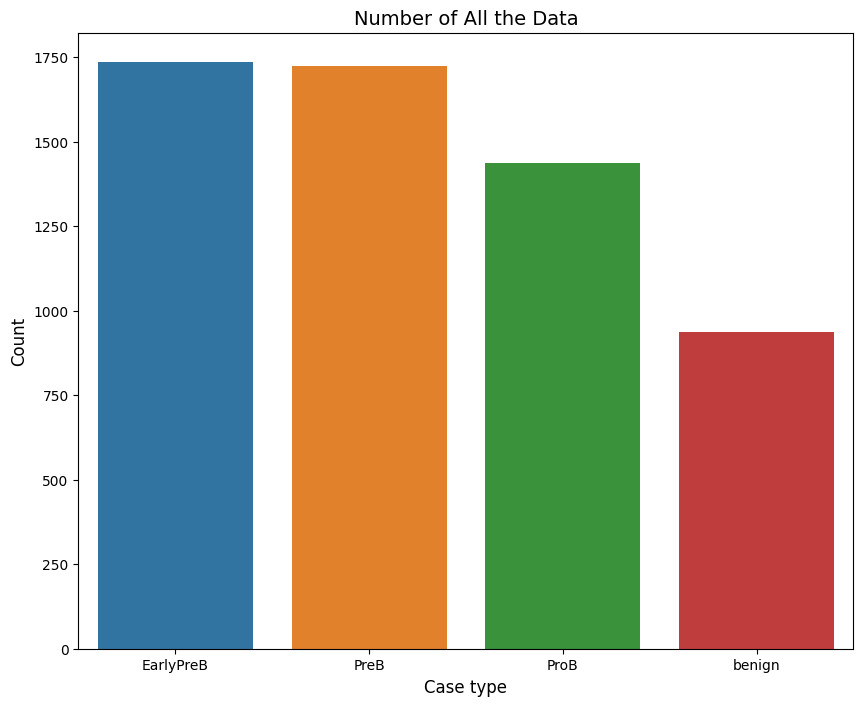

In [24]:
# Use actual labels for visualization
labels = actual_labels
values = [label_counts[label] for label in labels]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(labels)]

plt.figure(figsize=(10, 8))
sns.barplot(x=labels, y=values, palette=colors)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [25]:
# Split dataset
print(f"\n🔄 Splitting dataset with ratio {SPLIT}...")
TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88, stratify=df['labels'])

print(f'Train samples: {len(TRAIN_DF)}')
print(f'Valid samples: {len(VALID_DF)}')
print(f'Test samples: {len(test_df)}')


🔄 Splitting dataset with ratio 0.9...
Train samples: 5250
Valid samples: 584
Test samples: 325


#### Step 5: Create Optimized Datasets


In [26]:
# Create optimized datasets
print("\n🚀 Creating optimized datasets...")

# Get all unique labels from both train and test data
all_train_labels = set(TRAIN_DF['labels'].unique())
all_test_labels = set(test_df['labels'].unique())
all_labels = sorted(list(all_train_labels.union(all_test_labels)))

print(f"All unique labels across datasets: {all_labels}")


🚀 Creating optimized datasets...
All unique labels across datasets: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [27]:
# Create datasets using consistent labels
train_dataset, train_class_names = create_dataset_from_dataframe(TRAIN_DF, BATCH_SIZE, shuffle=True, augment=True)
valid_dataset, valid_class_names = create_dataset_from_dataframe(VALID_DF, BATCH_SIZE, shuffle=False, augment=False)
test_dataset, test_class_names = create_dataset_from_dataframe(test_df, BATCH_SIZE, shuffle=False, augment=False)


Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [28]:
# Use the most comprehensive class names
class_names = train_class_names  # Usually training set has all classes
print(f"Final class names: {class_names}")

Final class names: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [29]:
# Verify consistency
print(f"Train classes: {train_class_names}")
print(f"Valid classes: {valid_class_names}")
print(f"Test classes: {test_class_names}")


Train classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Valid classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Test classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']



🖼️ Displaying sample training images...


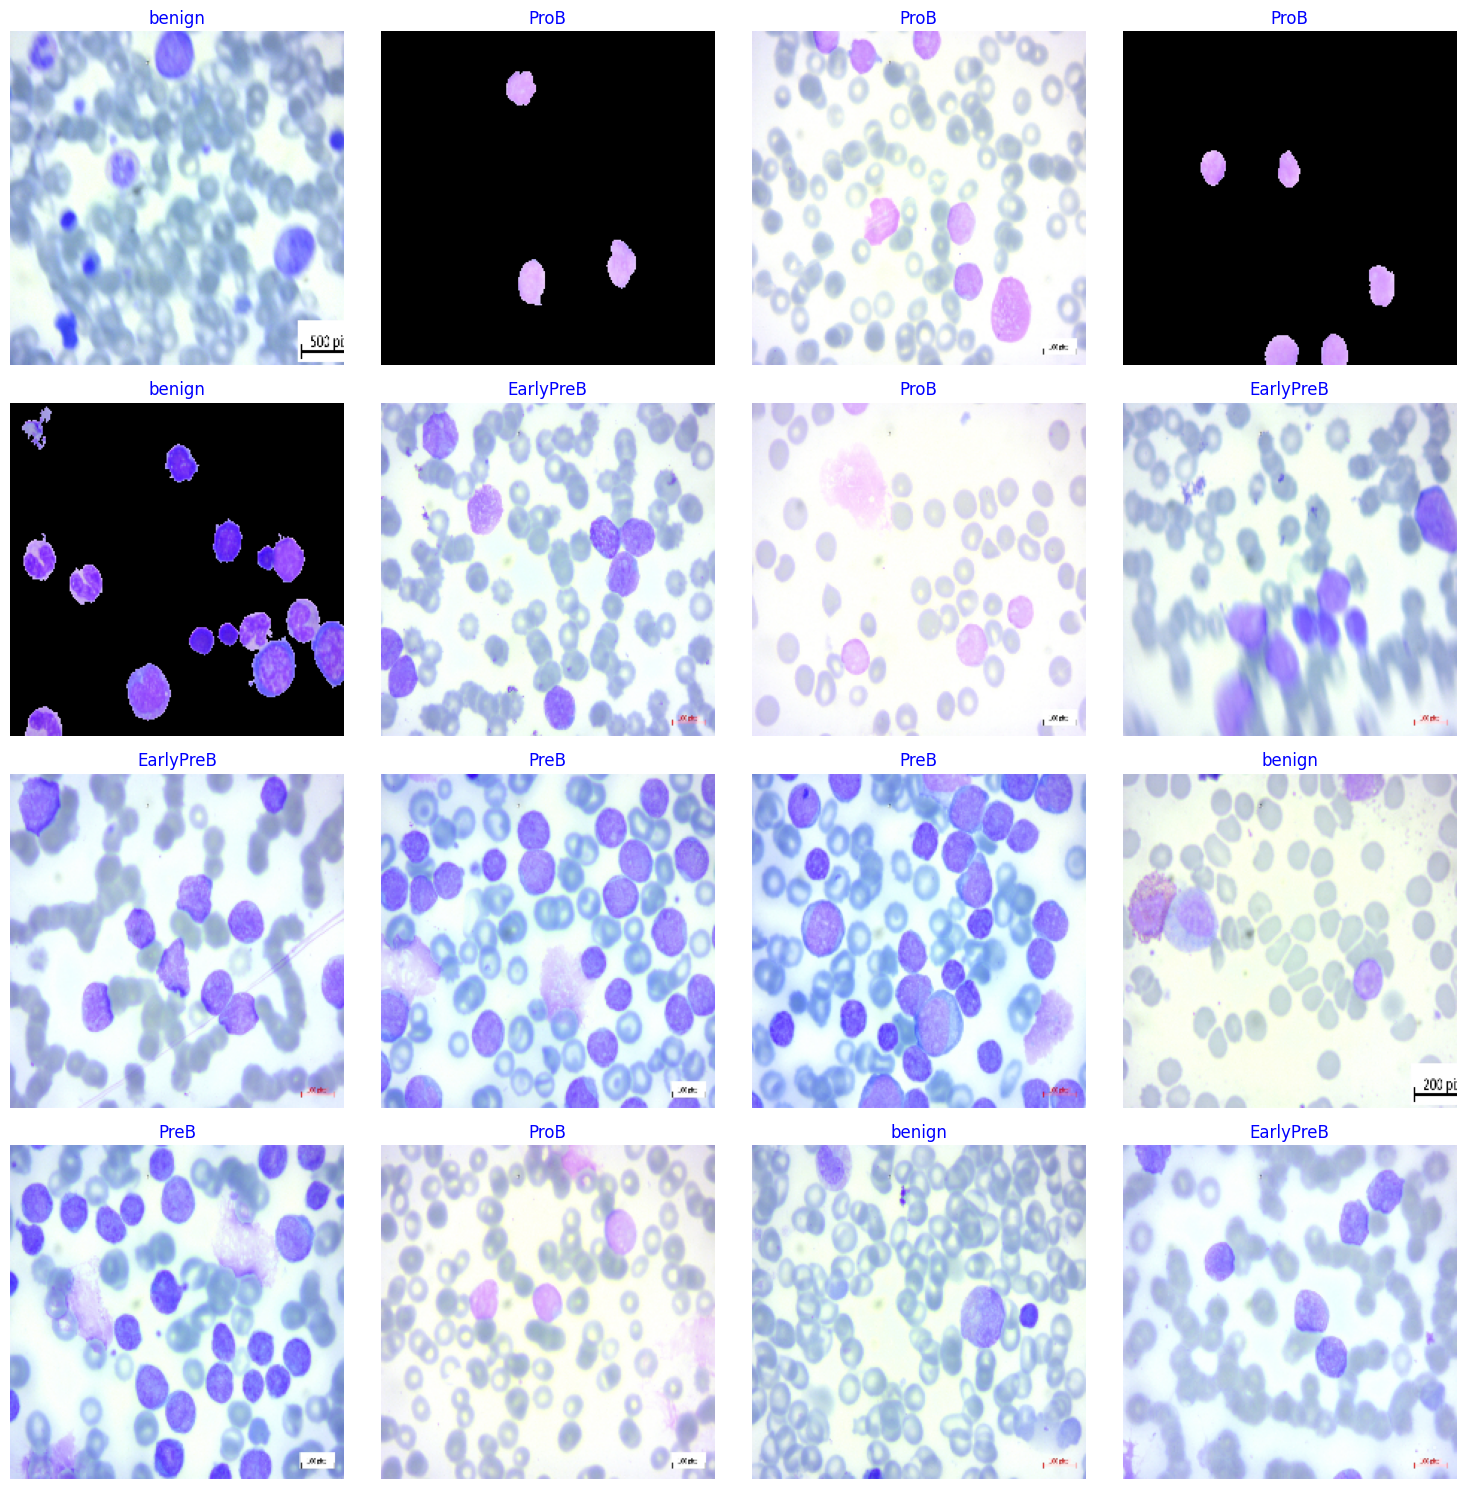

In [30]:
# Display sample images using traditional method (faster for preview)
print("\n🖼️ Displaying sample training images...")

# Take a small sample of files for quick preview
sample_files = TRAIN_DF.sample(n=16, random_state=88)

plt.figure(figsize=(15, 15))
for i, (idx, row) in enumerate(sample_files.iterrows()):
    if i >= 16:
        break

    plt.subplot(4, 4, i+1)

    # Quick image loading for preview
    img_path = row['filenames']
    try:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
            plt.title(row['labels'], color='blue', fontsize=12)
        else:
            plt.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f"{row['labels']} (Error)", color='red', fontsize=12)
    except Exception as e:
        plt.text(0.5, 0.5, f'Error:\n{str(e)[:20]}...', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f"{row['labels']} (Error)", color='red', fontsize=12)

    plt.axis('off')

plt.tight_layout()
plt.show()

## 🏥 MedNet Training and Fine-Tuning Pipeline

#### 🧱 Build the MedNet Model

In [31]:
# Build MedNet model
print("\n🏗️ Building MedNet model...")
model = create_mednet_model(len(class_names))

print("Number of layers:", len(model.layers))
print("Model input shape:", model.input.shape)
model.summary()


🏗️ Building MedNet model...
Number of layers: 19
Model input shape: (None, 224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 112,196 (438.27 KB)

 Trainable params: 111,236 (434.52 KB)

 Non-trainable params: 960 (3.75 KB)

#### 📉 Learning Rate Scheduler & Model Compilation

In [32]:
# Learning Rate Scheduler
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=80,
    decay_rate=0.96,
    staircase=False
)

# Compile the MedNet model with mixed precision
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=['accuracy']
)

print(f"MedNet model built successfully! Total parameters: {model.count_params():,}")

MedNet model built successfully! Total parameters: 112,196


#### 🧠 Callbacks Configuration

In [33]:
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mednet_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

#### 📊 Calculate Steps per Epoch


In [34]:
# Calculate steps per epoch
train_steps = len(TRAIN_DF) // BATCH_SIZE
valid_steps = len(VALID_DF) // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {valid_steps}")


Training steps per epoch: 82
Validation steps per epoch: 9


#### 🚀 Initial Training of MedNet


In [35]:
# Train model
print("\n🚀 Starting initial training...")
history = model.fit(
    train_dataset,
    epochs=10,  # Initial training epochs
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
    verbose=1
)


🚀 Starting initial training...
Epoch 1/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5050 - loss: 1.3221
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to best_mednet_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 2281s 23s/step - accuracy: 0.5072 - loss: 1.3152 - val_accuracy: 0.2639 - val_loss: 1.4743 - learning_rate: 9.5951e-05
Epoch 2/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 7:45 6s/step - accuracy: 0.5000 - loss: 0.6259

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.26389
82/82 ━━━━━━━━━━━━━━━━━━━━ 38s 400ms/step - accuracy: 0.5000 - loss: 0.6259 - val_accuracy: 0.2639 - val_loss: 1.4768 - learning_rate: 9.5951e-05
Epoch 3/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7213 - loss: 0.6976
Epoch 3: val_accuracy did not improve from 0.26389
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 352ms/step - accuracy: 0.7216 - loss: 0.6972 - val_accuracy: 0.2639 - val_loss: 1.4561 - learning_rate: 9.2019e-05
Epoch 4/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 2.9827
Epoch 4: val_accuracy did not improve from 0.26389
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0000e+00 - loss: 2.9827 - val_accuracy: 0.2639 - val_loss: 1.4571 - learning_rate: 9.1972e-05
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7658 - loss: 0.6033
Epoch 5: val_accuracy improved from 0.26389 to 0.35417, saving model to best_mednet_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.7660 - loss: 0.6029 - val_accuracy: 0.3542 - val_loss: 1.3222 - learning_rate: 8.8203e-05
Epoch 6/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5000 - loss: 0.9328
Epoch 6: val_accuracy did not improve from 0.35417
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5000 - loss: 0.9328 - val_accuracy: 0.3542 - val_loss: 1.3196 - learning_rate: 8.8158e-05
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8190 - loss: 0.4944
Epoch 7: val_accuracy improved from 0.35417 to 0.55035, saving model to best_mednet_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 430ms/step - accuracy: 0.8189 - loss: 0.4945 - val_accuracy: 0.5503 - val_loss: 0.9871 - learning_rate: 8.4545e-05
Epoch 8/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5000 - loss: 2.7173
Epoch 8: val_accuracy did not improve from 0.55035
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5000 - loss: 2.7173 - val_accuracy: 0.5503 - val_loss: 0.9789 - learning_rate: 8.4502e-05
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8172 - loss: 0.4907
Epoch 9: val_accuracy improved from 0.55035 to 0.74826, saving model to best_mednet_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.8172 - loss: 0.4905 - val_accuracy: 0.7483 - val_loss: 0.6735 - learning_rate: 8.1040e-05
Epoch 10/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 1.8151
Epoch 10: val_accuracy improved from 0.74826 to 0.75174, saving model to best_mednet_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0000e+00 - loss: 1.8151 - val_accuracy: 0.7517 - val_loss: 0.6651 - learning_rate: 8.1040e-05
Restoring model weights from the end of the best epoch: 10.


#### 🔁 Fine-Tuning Strategy A: Varying Unfrozen Layers



In [36]:
# Fine-tuning Strategy A: Experiment with different numbers of unfrozen layers
print("\n🎯 Starting Fine-tuning Strategy A...")
fine_tune_histories_A = fine_tune_model_strategy_A(
    model,
    train_dataset,
    valid_dataset,
    unfreeze_layers_list=[5, 10, 15],
    lr=0.00001,
    epochs=10
)


🎯 Starting Fine-tuning Strategy A...

--- Fine-tuning with last 5 layers unfrozen ---
Total layers in model: 19
Unfreezing layer 14: batch_normalization_3
Unfreezing layer 15: dense
Unfreezing layer 16: batch_normalization_4
Unfreezing layer 17: dropout
Unfreezing layer 18: dense_1
Trainable parameters: 17,540
Non-trainable parameters: 94,656
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 287ms/step - accuracy: 0.7764 - loss: 0.5793 - val_accuracy: 0.8236 - val_loss: 0.4687 - learning_rate: 1.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 0.8027 - loss: 0.5296 - val_accuracy: 0.8390 - val_loss: 0.3937 - learning_rate: 1.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.8219 - loss: 0.4978 - val_accuracy: 0.8613 - val_loss: 0.3514 - learning_rate: 1.0000e-05
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - accuracy: 0.8317 - loss: 0.4604 - val_accuracy: 0.8682 - val_loss: 0.3320 - learning_rate: 1.0000e-05
Epoch 5/10
83/83 ━━━━━━━━━

#### 🔬 Fine-Tuning Strategy B: Unfreeze from Specific Block


In [37]:
# Fine-tuning Strategy B: Unfreeze from Block 3 onward
print("\n🎯 Starting Fine-tuning Strategy B...")
fine_tune_history_B, fine_tuned_model_B = fine_tune_model_strategy_B(
    model,
    train_dataset,
    valid_dataset,
    unfreeze_from_index=9,  # Start from Conv2D(128) layer
    lr=0.00001,
    epochs=10
)


🎯 Starting Fine-tuning Strategy B...

--- Fine-tuning from layer index 9 onward ---
Unfreezing layer 9: conv2d_2
Unfreezing layer 10: batch_normalization_2
Unfreezing layer 11: activation_2
Unfreezing layer 12: max_pooling2d_2
Unfreezing layer 13: global_average_pooling2d
Unfreezing layer 14: batch_normalization_3
Unfreezing layer 15: dense
Unfreezing layer 16: batch_normalization_4
Unfreezing layer 17: dropout
Unfreezing layer 18: dense_1
Trainable parameters: 91,652
Non-trainable parameters: 20,544
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.7936 - loss: 0.5348 - val_accuracy: 0.8305 - val_loss: 0.4469 - learning_rate: 1.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.8394 - loss: 0.4286 - val_accuracy: 0.8647 - val_loss: 0.3340 - learning_rate: 1.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.8352 - loss: 0.4355 - val_accuracy: 0.8921 - val_loss: 0.2937 - learning_rate: 1.0000e-05
Epoch 4/10
83/83 ━━━━━

#### 🏁 Final Model Selection

In [38]:
# Use the best performing model for final evaluation
# You can choose between the original model or fine-tuned models based on validation performance
final_model = fine_tuned_model_B  # or model, or best from fine_tune_histories_A

#### 📊 Enhanced Training History Plot



📊 Plotting initial training history...


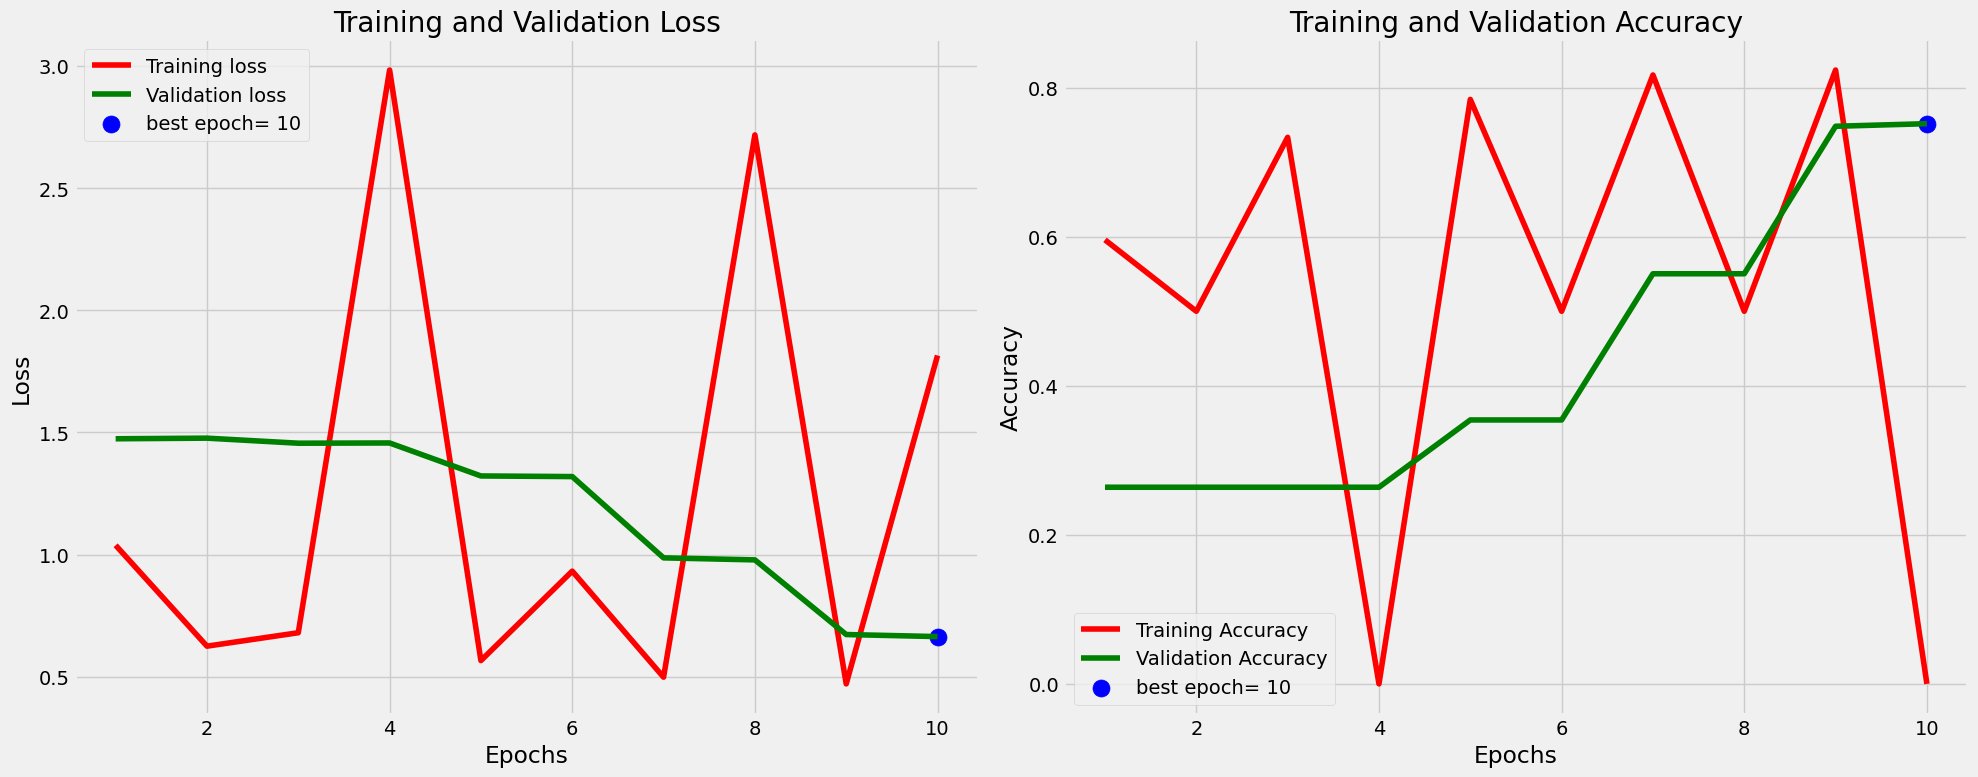

In [39]:
# Plot enhanced training history for initial training
print("\n📊 Plotting initial training history...")
tr_plot(history, 0)

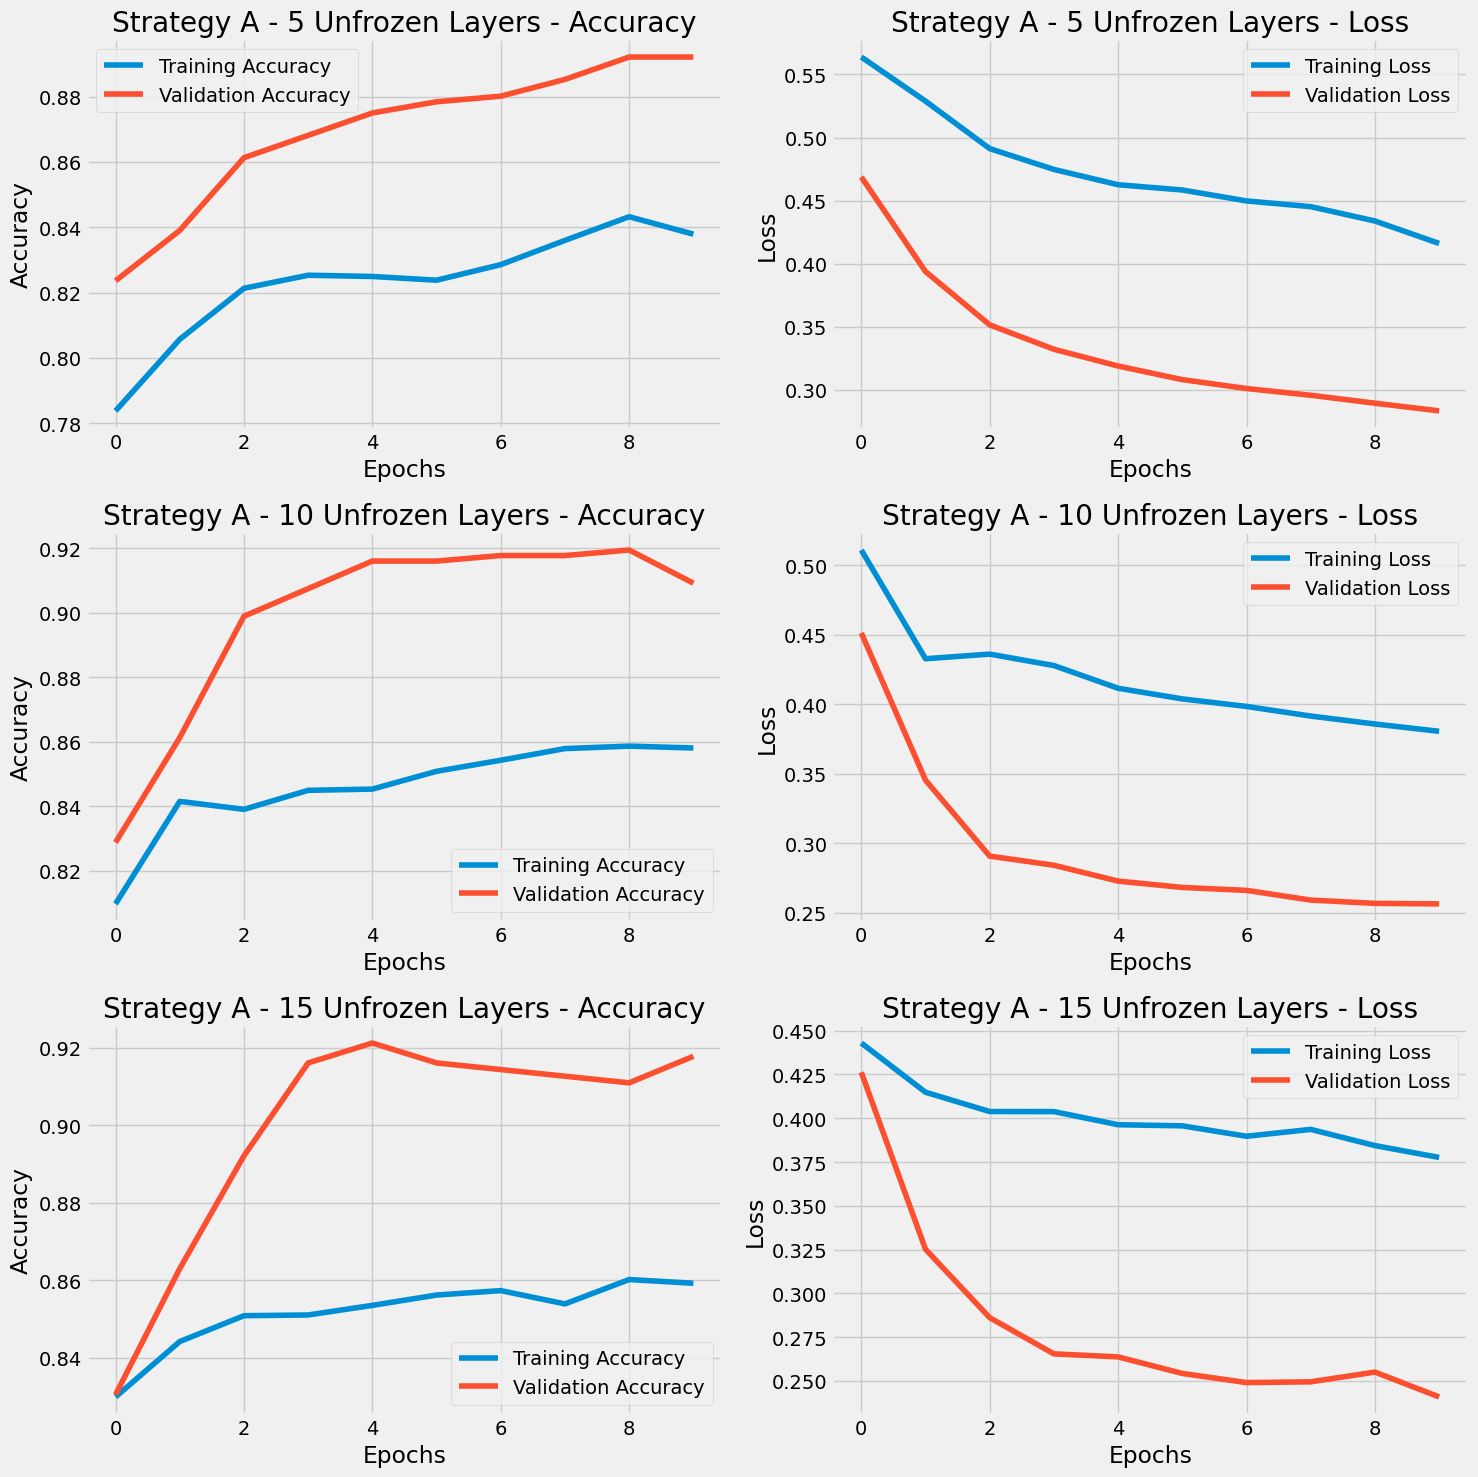

In [40]:
# Plot Strategy A results
if fine_tune_histories_A:
    fig, axes = plt.subplots(len(fine_tune_histories_A), 2, figsize=(15, 5*len(fine_tune_histories_A)))
    if len(fine_tune_histories_A) == 1:
        axes = axes.reshape(1, -1)

    for i, (unfrozen_layers, hist) in enumerate(fine_tune_histories_A.items()):
        # Accuracy plot
        axes[i, 0].plot(hist.history['accuracy'], label='Training Accuracy')
        axes[i, 0].plot(hist.history['val_accuracy'], label='Validation Accuracy')
        axes[i, 0].set_title(f'Strategy A - {unfrozen_layers} Unfrozen Layers - Accuracy')
        axes[i, 0].set_xlabel('Epochs')
        axes[i, 0].set_ylabel('Accuracy')
        axes[i, 0].legend()

        # Loss plot
        axes[i, 1].plot(hist.history['loss'], label='Training Loss')
        axes[i, 1].plot(hist.history['val_loss'], label='Validation Loss')
        axes[i, 1].set_title(f'Strategy A - {unfrozen_layers} Unfrozen Layers - Loss')
        axes[i, 1].set_xlabel('Epochs')
        axes[i, 1].set_ylabel('Loss')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

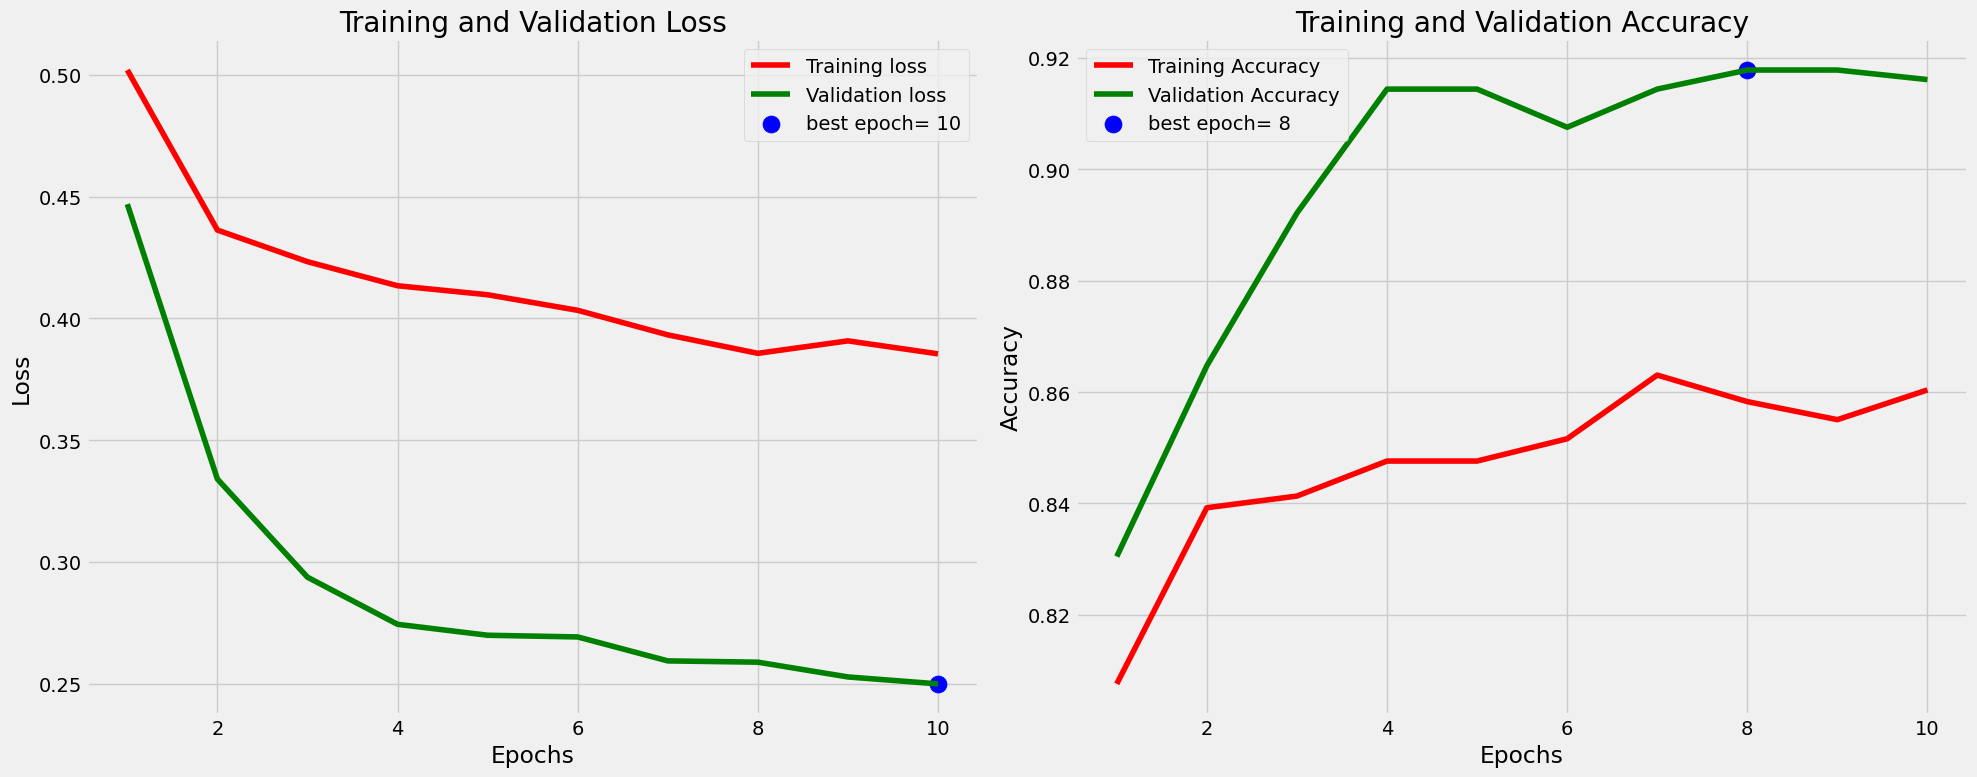

In [41]:
# Plot Strategy B results
tr_plot(fine_tune_history_B, 0)

## Evaluation and Results

#### Step 1: Test Set Evaluation

In [43]:
# Evaluate on test set
print("\n📊 Evaluating final model on test set...")
test_loss, test_accuracy = final_model.evaluate(test_dataset, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


📊 Evaluating final model on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 131s 21s/step - accuracy: 0.9883 - loss: 0.0958
✅ Test Accuracy: 98.15%


In [44]:
# Enhanced message display
acc = test_accuracy * 100
msg = f'MedNet Model accuracy on test set: {acc:.2f}%'
print(f"\n🎯 {msg}")


🎯 MedNet Model accuracy on test set: 98.15%


#### Step 2: Detailed Predictions Analysis

In [45]:
# Detailed predictions and analysis
print("\n🔍 Generating detailed predictions and analysis...")
predictions = final_model.predict(test_dataset, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)



🔍 Generating detailed predictions and analysis...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step


#### Step 3: Confusion Matrix Analysis


In [46]:
# Get true labels from test dataset
true_classes = []
for _, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))
true_classes = np.array(true_classes[:len(predicted_classes)])

In [47]:
# Calculate metrics
accuracy = metrics.accuracy_score(true_classes, predicted_classes)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Final Test Accuracy: 98.15%


In [48]:
# Confusion Matrix Analysis
matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", matrix)

Confusion Matrix:
 [[108   0   0   3]
 [  0  93   0   0]
 [  0   0  78   0]
 [  3   0   0  40]]


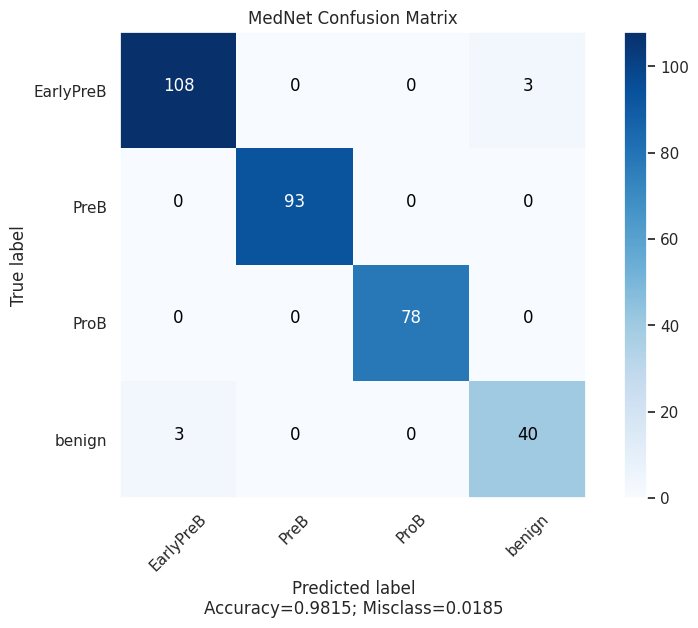

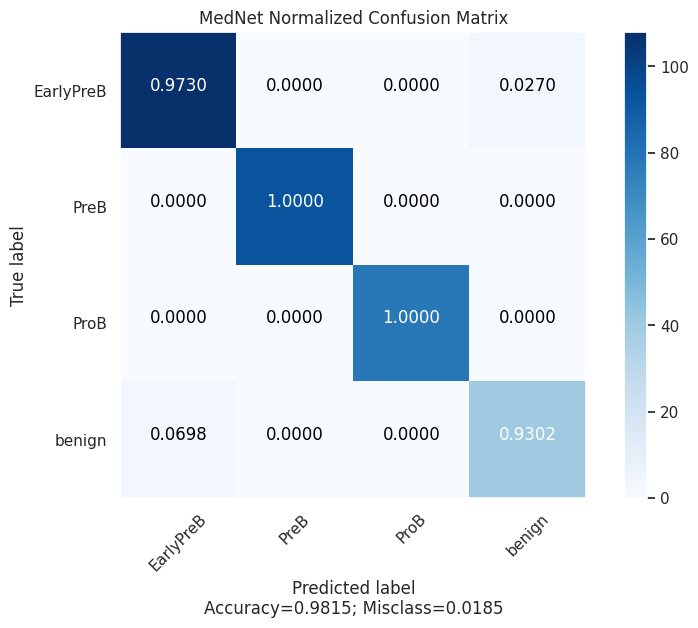

In [49]:
# Plot confusion matrices
plot_confusion_matrix(matrix,
                      class_names,
                      normalize=False,
                      title="MedNet Confusion Matrix")

plot_confusion_matrix(matrix,
                      class_names,
                      normalize=True,
                      title="MedNet Normalized Confusion Matrix")

In [50]:
# Calculate detailed metrics
TP = np.diag(matrix)
FP = matrix.sum(axis=0) - TP
FN = matrix.sum(axis=1) - TP
TN = matrix.sum() - (TP + FP + FN)

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)
MAE = mean_absolute_error(true_classes, predicted_classes)

print('\n📊 Detailed Metrics:')
print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (PPV) ----------------------------------:', PPV)
print('Recall (TPR) -------------------------------------:', TPR)
print('Specificity (TNR) -------------------------------:', TNR)
print('Negative Predictive Value ------------------------:', NPV)
print('Fall-out (FPR) -----------------------------------:', FPR)
print('False Negative Rate ------------------------------:', FNR)
print('False Discovery Rate -----------------------------:', FDR)

# Dice, IoU, Pixel Accuracy
dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
iou = TP / (TP + FP + FN + 1e-8)
pixel_acc = np.sum(TP) / np.sum(matrix)

print(f"\n🎯 Pixel Accuracy (from Confusion Matrix): {pixel_acc:.4f}")
for i in range(len(class_names)):
    print(f"\nClass: {class_names[i]}")
    print(f"  TP={TP[i]}, FP={FP[i]}, FN={FN[i]}")
    print(f"  Dice Coefficient (F1): {dice[i]:.4f}")
    print(f"  Intersection over Union (IoU): {iou[i]:.4f}")


📊 Detailed Metrics:
MAE ----------------------------------------------: 0.055384615384615386
Accuracy -----------------------------------------: [0.98153846 1.         1.         0.98153846]
Precision (PPV) ----------------------------------: [0.97297297 1.         1.         0.93023256]
Recall (TPR) -------------------------------------: [0.97297297 1.         1.         0.93023256]
Specificity (TNR) -------------------------------: [0.98598131 1.         1.         0.9893617 ]
Negative Predictive Value ------------------------: [0.98598131 1.         1.         0.9893617 ]
Fall-out (FPR) -----------------------------------: [0.01401869 0.         0.         0.0106383 ]
False Negative Rate ------------------------------: [0.02702703 0.         0.         0.06976744]
False Discovery Rate -----------------------------: [0.02702703 0.         0.         0.06976744]

🎯 Pixel Accuracy (from Confusion Matrix): 0.9815

Class: EarlyPreB
  TP=108, FP=3, FN=3
  Dice Coefficient (F1): 0.9730
  

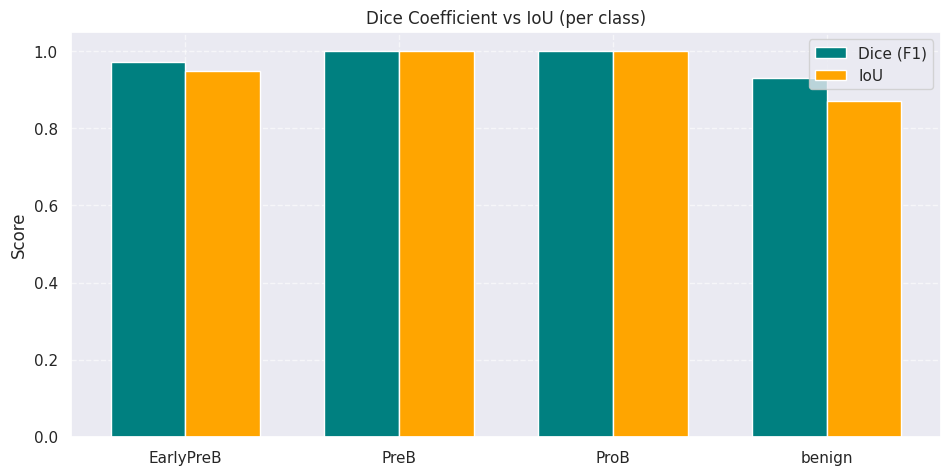

In [51]:
# Plot Dice vs IoU
x = np.arange(len(class_names))
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, dice, width, label='Dice (F1)', color='teal')
plt.bar(x + width/2, iou, width, label='IoU', color='orange')
plt.xticks(x, class_names)
plt.ylabel("Score")
plt.title("Dice Coefficient vs IoU (per class)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Step 4: Classification Report


In [52]:
# Classification report
print("\n📈 Classification Report:")
print(metrics.classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names
))


📈 Classification Report:
              precision    recall  f1-score   support

   EarlyPreB       0.97      0.97      0.97       111
        PreB       1.00      1.00      1.00        93
        ProB       1.00      1.00      1.00        78
      benign       0.93      0.93      0.93        43

    accuracy                           0.98       325
   macro avg       0.98      0.98      0.98       325
weighted avg       0.98      0.98      0.98       325



In [53]:
# Sample predictions visualization
print("\n🖼️ Visualizing sample predictions...")

# Convert test dataset to arrays for visualization
X_test = []
y_test = []
for images, labels in test_dataset.take(-1):  # Take all batches
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

print('Shape of predictions: ', predictions.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)


🖼️ Visualizing sample predictions...
Shape of predictions:  (325, 4)
Shape of X_test:  (325, 224, 224, 3)
Shape of y_test:  (325, 4)


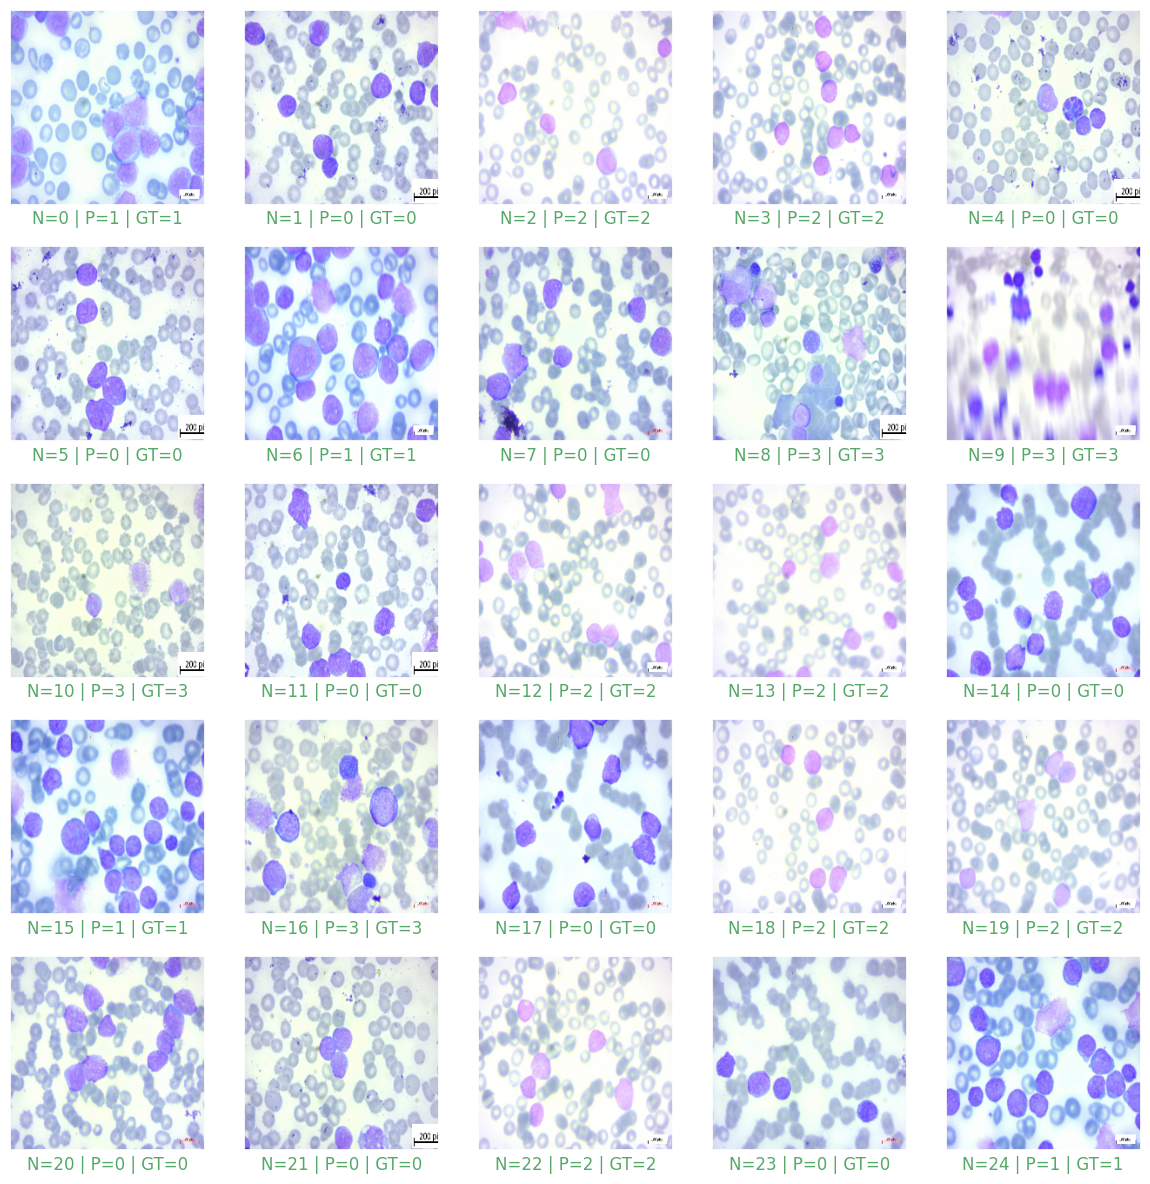

In [54]:
# Visualize sample predictions
plt.figure(figsize=(12, 12))
for i in range(min(25, len(X_test))):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Select image by index instead of random choice to avoid index errors
    number = i if i < len(predictions) else 0
    pred_label = np.argmax(predictions[number])
    actual_label = np.argmax(y_test[number])
    col = 'g' if pred_label == actual_label else 'r'
    plt.xlabel(f'N={number} | P={pred_label} | GT={actual_label}', color=col)

    # Display image
    img = X_test[number]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    plt.imshow(img)

plt.tight_layout()
plt.show()